In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold, train_test_split

In [2]:
columns = [
    'Make','Model','Year','Engine HP','Engine Cylinders',
    'Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP'
]

data = pd.read_csv('data.csv', usecols=columns)
data.head()

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


In [3]:
#@ Data preparation
data.columns = data.columns.str.lower().str.replace(' ', '_')

for col in list((data.dtypes[data.dtypes == 'object']).index):
    data[col] = data[col].str.lower().str.replace(' ', '_')
    
average_msrp = data['msrp'].mean()
data['msrp'] = (data['msrp'] >= average_msrp).astype(int)

data = data.fillna(0)
data.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,bmw,1_series_m,2011,335.0,6.0,manual,coupe,26,19,1
1,bmw,1_series,2011,300.0,6.0,manual,convertible,28,19,1
2,bmw,1_series,2011,300.0,6.0,manual,coupe,28,20,0
3,bmw,1_series,2011,230.0,6.0,manual,coupe,28,18,0
4,bmw,1_series,2011,230.0,6.0,manual,convertible,28,18,0


In [4]:
#@ splitting the dataset
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train['msrp'].values
y_val = df_val['msrp'].values
y_test = df_test['msrp'].values

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Q1

In [5]:
#@ computing auc_score of all numerical columns against the msrp
numerical = ['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
for col in numerical:
    auc_score = roc_auc_score(y_train, df_train[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[col])
        
    print(col,' -> ',auc_score)

year  ->  0.687551492804683
engine_hp  ->  0.9171031265539011
engine_cylinders  ->  0.766116490165669
highway_mpg  ->  0.6330587871772013
city_mpg  ->  0.6734244643245233


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

`LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`

What's the AUC of this model on the validation dataset? (round to 3 digits)

    0.678
    0.779
    0.878
    0.979


In [6]:
categorical = list((df_train.dtypes[df_train.dtypes == 'object']).index)

In [7]:
#@ training the model

dv = DictVectorizer(sparse=False)
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

train_dict = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
model.fit(X_train, y_train)

val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:,1]

In [8]:
roc_auc_score(y_val, y_pred)

0.9765734024546191

# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

    0.28
    0.48
    0.68
    0.88


In [9]:
def confusion_matrix(actual, predicted):
    threshold = np.arange(0.1, 1.0, 0.01)
    scores = []
    
    for t in threshold:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        predicted_positive = (y_pred >= t)
        predicted_negative = (y_pred < t)

        true_positive = (actual_positive & predicted_positive).sum()
        true_negative = (actual_negative & predicted_negative).sum()
        false_positive = (actual_negative & predicted_positive).sum()
        false_negative = (actual_positive & predicted_negative).sum()
        
        precision = true_positive/(true_positive + false_positive)
        recall = true_positive/(true_positive + false_negative)
        
        scores.append((t,true_negative,true_positive,false_negative,
                       false_positive, precision, recall))
        
    cols = ['threshold','true_negative','true_positive','false_negative',
            'false_positive', 'precision', 'recall']
    df_scores = pd.DataFrame(scores,columns=cols)

    return df_scores

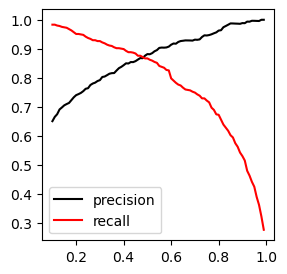

In [10]:
df_scores = confusion_matrix(y_val, y_pred)

plt.figure(figsize=((3,3)))
plt.plot(df_scores['threshold'], df_scores['precision'], label='precision', color='Black')
plt.plot(df_scores['threshold'], df_scores['recall'], label='recall', color='Red')
plt.legend()
plt.show()

# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

In [11]:
df_scores['f1_score'] = 2 *( (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall) )
df_scores[df_scores.f1_score == df_scores.f1_score.max()]

,threshold,true_negative,true_positive,false_negative,false_positive,precision,recall,f1_score
40,0.5,1653,567,87,76,0.881804,0.866972,0.874325


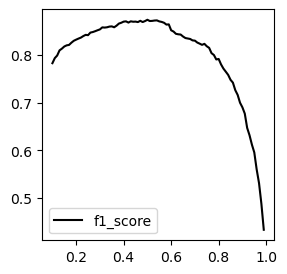

In [12]:
#@ visualizing the peak f1_score

plt.figure(figsize=((3,3)))
plt.plot(df_scores['threshold'], df_scores['f1_score'], label='f1_score', color='Black')
plt.legend()
plt.show()

# Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [13]:
def train(series, target, C):
    dv = DictVectorizer(sparse=False)
    series_dict = series.to_dict(orient='records')
    X = dv.fit_transform(series_dict)
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X, target)
    
    return dv, model

def predict(dv, model, series):
    series_dict = series.to_dict(orient='records')
    X = dv.transform(series_dict)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred

In [14]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['msrp'].values
    y_val = df_val['msrp'].values
    
    del df_train['msrp']
    del df_val['msrp']
    
    dv, model = train(df_train, y_train, C= 1.0)
    y_pred = predict(dv, model, df_val)
    
    auc_score = roc_auc_score(y_val, y_pred)
    
    scores.append(auc_score)

0it [00:00, ?it/s]

In [15]:
np.std(scores)

0.003025194365282419

# Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [16]:
for C in tqdm([0.01, 0.1, 0.5, 10]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['msrp'].values
        y_val = df_val['msrp'].values

        del df_train['msrp']
        del df_val['msrp']

        dv, model = train(df_train, y_train, C)
        y_pred = predict(dv, model, df_val)

        auc_score = roc_auc_score(y_val, y_pred)


        scores.append((C, auc_score))
        
        
    print('C: %.3f --> AUC: %.5f | Mean: %.3f | Std: %.3f'%(C, auc_score, np.mean(scores), np.std(scores)) )

  0%|          | 0/4 [00:00<?, ?it/s]

C: 0.010 --> AUC: 0.95024 | Mean: 0.481 | Std: 0.471
C: 0.100 --> AUC: 0.97338 | Mean: 0.536 | Std: 0.436
C: 0.500 --> AUC: 0.97771 | Mean: 0.740 | Std: 0.240
C: 10.000 --> AUC: 0.98772 | Mean: 5.492 | Std: 4.508
